In [398]:
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
import math
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import GBTRegressor, LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import Column, Window
from pyspark.sql.types import DoubleType
from statsmodels.tsa.seasonal import seasonal_decompose

In [399]:
import matplotlib.pyplot as plt

In [400]:
APP_NAME = 'Taxi'
SPARK_URL = 'local[*]'

In [401]:
spark = SparkSession.builder.appName(APP_NAME).config('spark.ui.showConsoleProgress', 'false').getOrCreate()

#### Data overview

In [402]:
taxi = spark.read.csv('Taxi_Trips_-_2022.csv', header='true', inferSchema = 'true')

In [403]:
taxi_2023 = spark.read.csv('Taxi_Trips_-_2023.csv', header='true', inferSchema = 'true')

In [404]:
taxi.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [405]:
taxi_2023[['Trip ID',
 'Taxi ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Community Area',]].describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+------------------+----------------+---------------------+
|summary|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|      Trip Seconds|      Trip Miles|Pickup Community Area|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+----------------+---------------------+
|  count|             3783730|             3783730|             3783730|             3783682|           3783012|         3783717|              3615963|
|   mean|                null|                null|                null|                null|1235.3278387697421|6.47123319476644|    35.03091652209937|
| stddev|                null|                null|                null|                null|1736.5661018295136|7.59331044121222|   26.078720147019546|
|    min|0000012deb83dbb55...|00110971c7c4a7173...|01/01/2023 01:00:...|01/01/2023 01:00

In [406]:
taxi.count()

6382425

In [407]:
taxi.columns

['Trip ID',
 'Taxi ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Census Tract',
 'Dropoff Census Tract',
 'Pickup Community Area',
 'Dropoff Community Area',
 'Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'Payment Type',
 'Company',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Pickup Centroid Location',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude',
 'Dropoff Centroid  Location']

In [408]:
#taxi.limit(20).collect()[:]

In [409]:
taxi[['Trip ID',
 'Taxi ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Community Area',]].describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+------------------+-----------------+---------------------+
|summary|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|      Trip Seconds|       Trip Miles|Pickup Community Area|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+-----------------+---------------------+
|  count|             6382425|             6382425|             6382425|             6382213|           6380960|          6382369|              5868572|
|   mean|                null|                null|                null|                null|1198.2085212883328|6.185568905527588|    32.35048253646713|
| stddev|                null|                null|                null|                null| 1895.664878082732|   8.002858369488|   25.203045304909356|
|    min|000000bb18f0563c1...|0041f8f0c91881c1e...|01/01/2022 01:00:...|01/01/2022

In [410]:
taxi[['Pickup Community Area']].describe().show()

+-------+---------------------+
|summary|Pickup Community Area|
+-------+---------------------+
|  count|              5868572|
|   mean|    32.35048253646713|
| stddev|   25.203045304909356|
|    min|                    1|
|    max|                   77|
+-------+---------------------+



In [411]:
taxi[['Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total']].describe().show()

+-------+------------------+------------------+-------------------+-----------------+------------------+
|summary|              Fare|              Tips|              Tolls|           Extras|        Trip Total|
+-------+------------------+------------------+-------------------+-----------------+------------------+
|  count|           6378889|           6378889|            6378889|          6378889|           6378889|
|   mean| 21.72931312020104|2.7545550142038486|0.02128382074057096|2.163035586604502| 26.82509761809589|
| stddev|49.416238999460845|  4.08389167014634|  7.659938846744798|21.75269211485504|56.964604407228194|
|    min|               0.0|               0.0|                0.0|              0.0|               0.0|
|    max|           9999.75|             496.0|            6666.66|          8888.88|           9999.75|
+-------+------------------+------------------+-------------------+-----------------+------------------+



Choosing features for taxi count calculation for every moment in time. We don't need information about dropoffs, trip ending timestamp and about census tract.

In [412]:
taxi = taxi.select(
 'Trip Start Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Community Area',
 'Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude'
)


In [413]:
taxi_2023 = taxi_2023.select(
 'Trip Start Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Community Area',
 'Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude'
)


## Missing Data

In [414]:
def percentage_missings(df):
    nan_df = df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()
    nan_df = nan_df/df.count()
    return nan_df

In [415]:
def plot_missings(df):
    nan = percentage_missings(df)
    nan.plot.bar(figsize=(12,8))

#### 2022

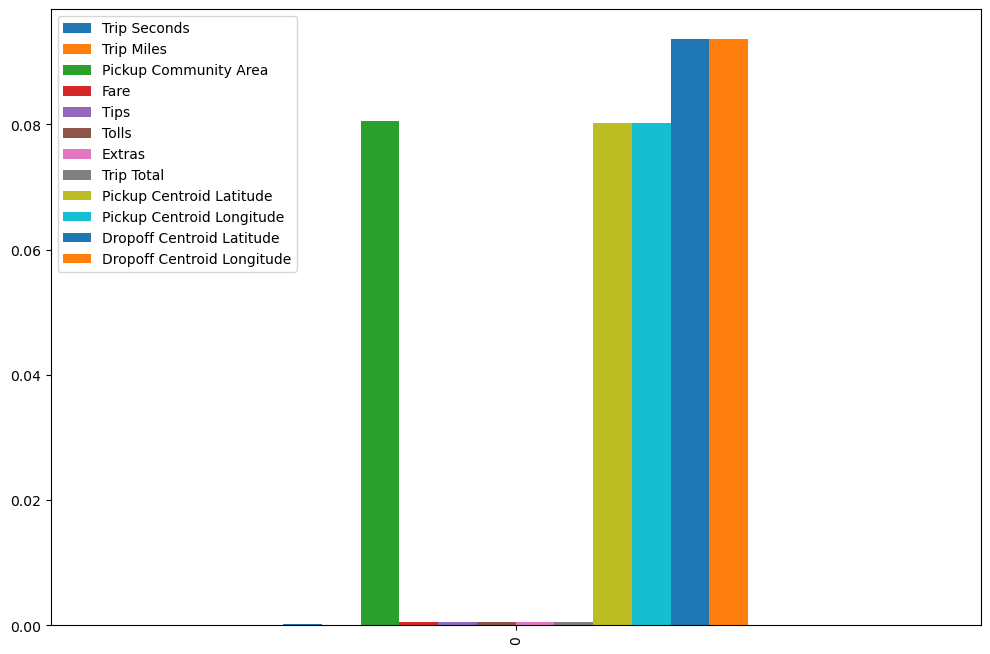

In [416]:
plot_missings(taxi)

In [417]:
taxi_nan = percentage_missings(taxi)

<Axes: >

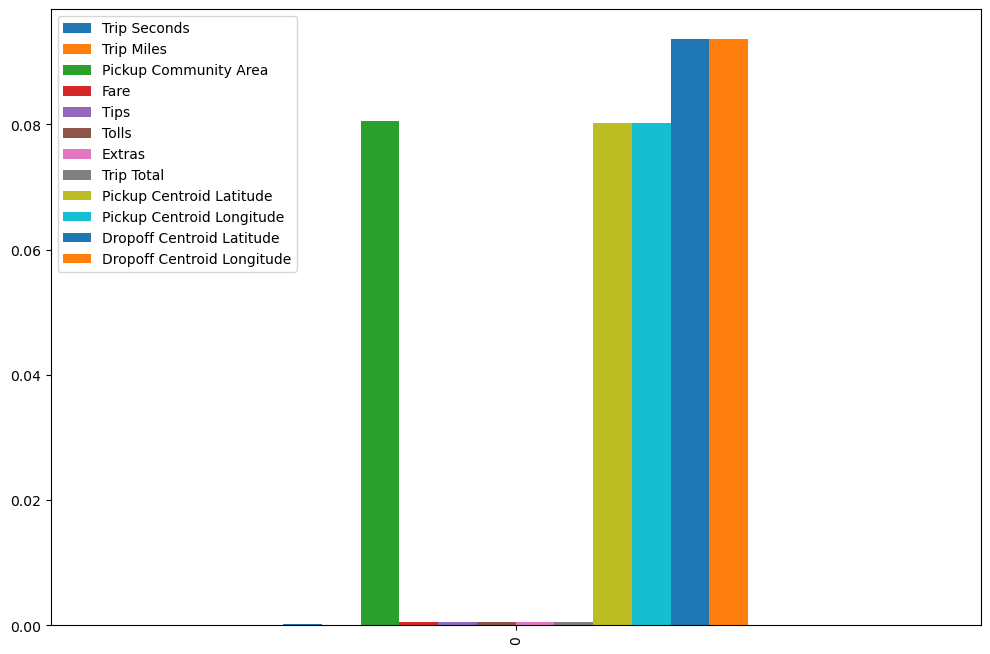

In [418]:
taxi_nan.plot.bar(figsize=(12,8))

Removing pickup community area nan values (as they are the source of our target variables):

In [419]:
taxi = taxi.filter(taxi['Pickup Community Area'].isNotNull())

In [420]:
taxi_nan = percentage_missings(taxi)

<Axes: >

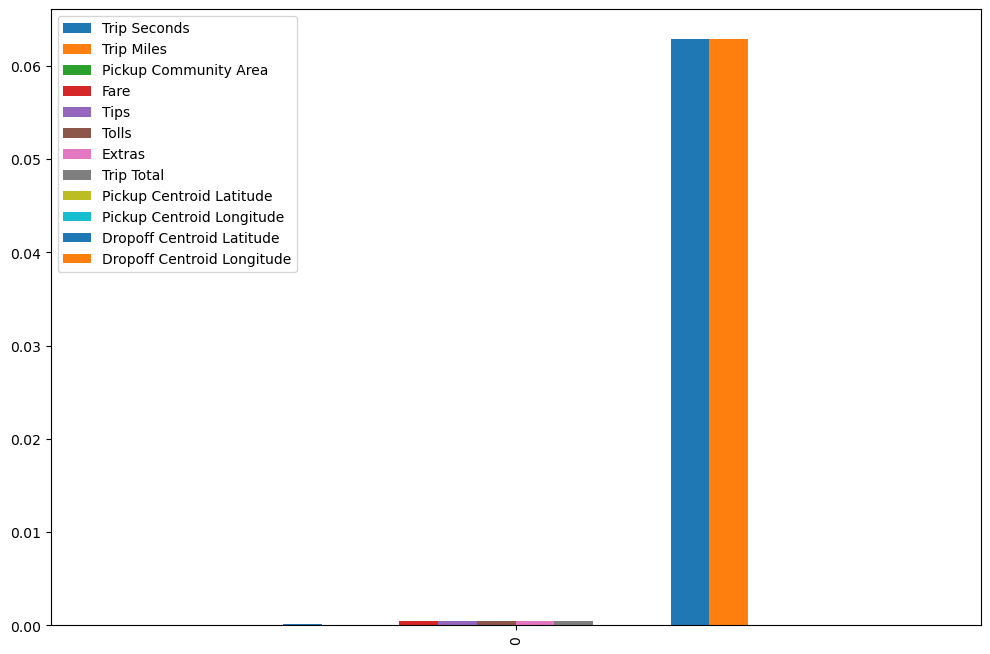

In [421]:
taxi_nan.plot.bar(figsize=(12,8))

Count of nulls in remaining columns is insignificant (less than 0.05%) so we can remove those.

In [422]:
taxi = taxi.dropna(how='any')

In [423]:
taxi.count()

5495741

#### 2023

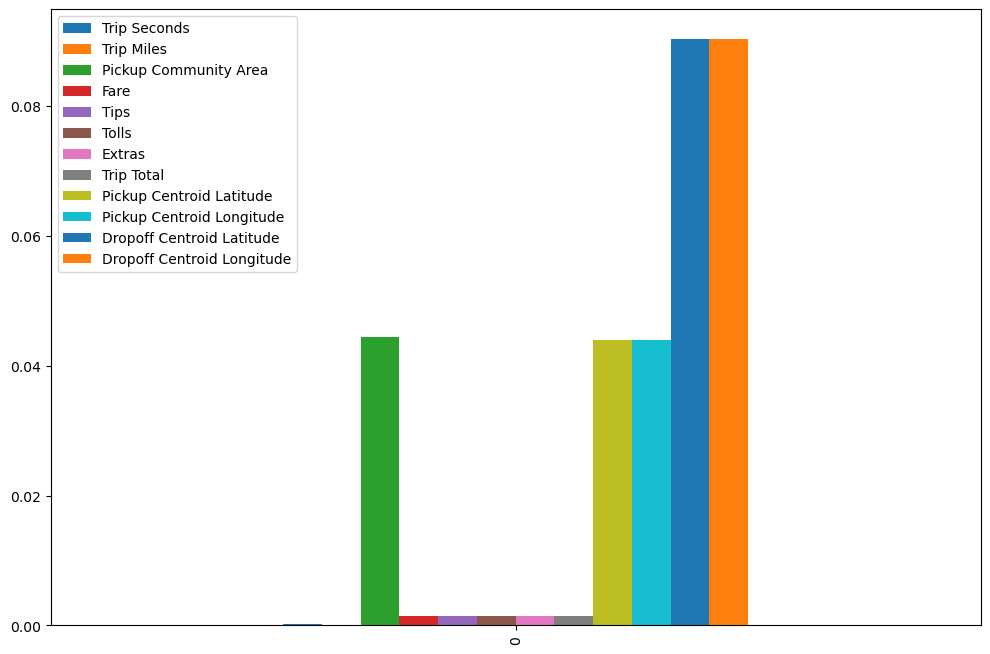

In [424]:
plot_missings(taxi_2023)

In [425]:
taxi_2023.count()

3783730

In [426]:
taxi_2023 = taxi_2023.filter(taxi_2023['Pickup Community Area'].isNotNull())

In [427]:
taxi_2023.count()

3615963

In [428]:
#fix 'any' to previos
taxi_2023 = taxi_2023.dropna(how='any')

In [429]:
taxi_2023.count()

3362423

In [430]:
#taxi_nan.plot.bar(figsize=(12,8))

#### Merging dataframes

In [431]:
taxi = taxi.union(taxi_2023)

### Direct Distance between pickup and dropoff

In [432]:
def calculate_distance(start_latitude, start_longitude, end_latitude, end_longitude):
    return math.dist((start_latitude, start_longitude), (end_latitude, end_longitude))

In [433]:
calculate_distance_udf = F.udf(calculate_distance, DoubleType())

In [434]:
taxi = taxi.withColumn('direct_distance', F.lit(calculate_distance_udf(
    'Pickup Centroid Latitude',
    'Pickup Centroid Longitude',
    'Dropoff Centroid Latitude', 
    'Dropoff Centroid Longitude')))

In [435]:
taxi = taxi.drop('Pickup Centroid Latitude',
    'Pickup Centroid Longitude',
    'Dropoff Centroid Latitude',
    'Dropoff Centroid Longitude')

In [436]:
taxi = taxi.withColumn('taxi_count', F.lit(1))

In [437]:
taxi.columns

['Trip Start Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Community Area',
 'Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'direct_distance',
 'taxi_count']

In [438]:
taxi.show()

+--------------------+------------+----------+---------------------+-----+----+-----+------+----------+--------------------+----------+
|Trip Start Timestamp|Trip Seconds|Trip Miles|Pickup Community Area| Fare|Tips|Tolls|Extras|Trip Total|     direct_distance|taxi_count|
+--------------------+------------+----------+---------------------+-----+----+-----+------+----------+--------------------+----------+
|01/01/2022 12:00:...|         536|      4.83|                   28|14.75| 0.0|  0.0|   0.0|     14.75| 0.06039143502879897|         1|
|01/01/2022 12:00:...|         897|      2.07|                    8| 9.75| 0.0|  0.0|   1.5|     11.25| 0.02226816794603169|         1|
|01/01/2022 12:00:...|        2200|      2.48|                    8| 9.36|2.14|  0.0|   0.0|      11.5| 0.02226816794603169|         1|
|01/01/2022 12:00:...|           0|       0.0|                   33| 3.25| 0.0|  0.0|   0.0|      3.25|                 0.0|         1|
|01/01/2022 12:00:...|          33|      0.17|  

In [439]:
## direct distance and trip miles distribution

### Transforming Data

In [440]:
taxi = taxi.withColumn('trip_date', F.to_timestamp(taxi['Trip Start Timestamp'], 'MM/dd/yyyy hh:mm:ss a')).drop('Trip Start Timestamp')
taxi = taxi.withColumn('trip_date', F.date_trunc('hour', taxi['trip_date']))


In [441]:
taxi_transformed = taxi.groupby(['trip_date','Pickup Community Area']).agg({
    'Trip Seconds':'mean', 
    'Trip Miles': 'mean', 
    'taxi_count':'count',
    'Fare':'mean',
    'Tips':'mean',
    'Tolls':'mean',
    'Extras':'mean',
    'Trip Total':'mean',
    'direct_distance':'mean'}).orderBy(['trip_date','Pickup Community Area'])
taxi_transformed

DataFrame[trip_date: timestamp, Pickup Community Area: int, avg(Trip Total): double, count(taxi_count): bigint, avg(Trip Seconds): double, avg(Tips): double, avg(Extras): double, avg(Trip Miles): double, avg(Fare): double, avg(direct_distance): double, avg(Tolls): double]

In [442]:
#pandas_avg = taxi_transformed.select('trip_date', 'Pickup Community Area', 'avg(Trip Total)').toPandas().set_index('trip_date')

In [443]:
#for i in [7+1,27+1,31+1,32+1]:
#pandas_avg_gr = pandas_avg.groupby(by='trip_date').mean()

#pandas_avg_gr['avg(Trip Total)'].hist(bins=100, figsize=(12,6), range=(0,60))
#plt.show()
#pandas_avg[pandas_avg['Pickup Community Area'].isin()].hist(bins=100)

## Seasonality

In [444]:
days = 60 * 60 * 24
seasonal_data = taxi_transformed[['trip_date','count(taxi_count)']].groupBy('trip_date').agg({'count(taxi_count)' : 'mean'}).orderBy('trip_date')
w = Window.orderBy(F.col('trip_date').cast('long')).rangeBetween(-days, 0)
seasonal_data = seasonal_data.withColumn('rolling_mean', F.avg('avg(count(taxi_count))').over(w))

#decomposed = seasonal_decompose(seasonal_data.toPandas()['trip_date'])
#decomposed.seasonal['2022-01':'2022-02'].plot(ax=plt.gca())

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


<Axes: xlabel='trip_date'>

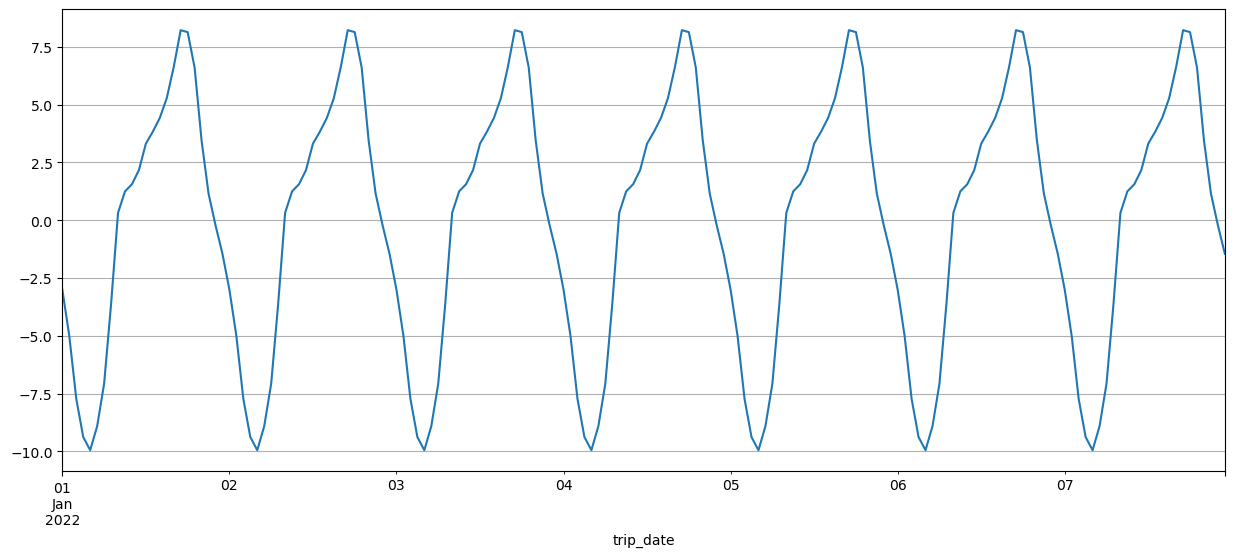

In [445]:
seasonal_p = seasonal_data.toPandas()
seasonal_p = seasonal_p.set_index('trip_date')
seasonal_p = seasonal_p.asfreq('H')
#seasonal_p.index.freq = 'H'
seasonal_p = seasonal_p.fillna(0)
decomposed = seasonal_decompose(seasonal_p['avg(count(taxi_count))'])
decomposed.seasonal['2022-01-01':'2022-01-07'].plot(ax=plt.gca(), figsize = (15,6), grid=True)

<Axes: xlabel='trip_date'>

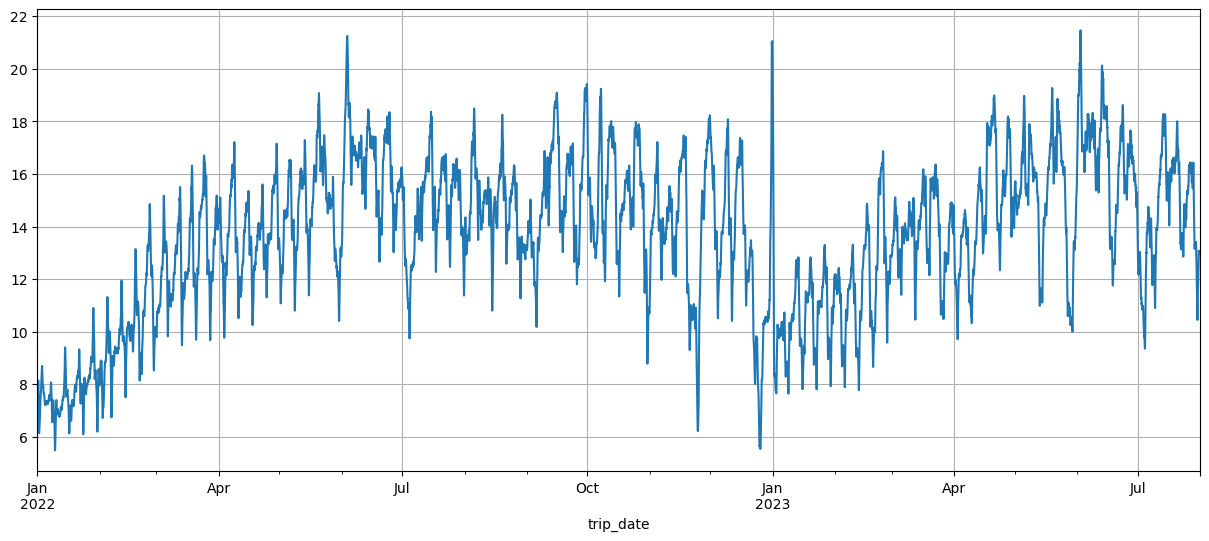

In [446]:
decomposed.trend.plot(ax=plt.gca(), figsize = (15,6), grid=True)

In [447]:
def get_time_series_per_area(taxi_transformed, area_num, template_dates):
    areas = []
    for i in range(1, area_num+1):
        area_data = taxi_transformed.filter(taxi_transformed['Pickup Community Area'] == i).drop('Pickup Community Area')
        joined_data = template_dates
        joined_data = joined_data.join(area_data, joined_data.date == area_data.trip_date, 'left')
        joined_data = joined_data.drop('trip_date').na.fill(0)
        areas.append(joined_data.orderBy('date'))
    return areas

In [448]:
def generate_time_series(start, stop, interval):
    start, stop = spark.createDataFrame(
        [(start, stop)], ('start', 'stop')).select(
        [F.col(c).cast('timestamp').cast('long') for c in ('start', 'stop')]).first()
    return spark.range(start, stop, interval).select(
        F.col('id').cast('timestamp').alias('date'))

In [449]:
#spark.createDataFrame(data=[], schema=taxi_transformed.drop('trip_Date').schema)

In [450]:
template = generate_time_series('2022-01-01', '2023-08-01', 3600)
#template_2023 = generate_time_series('2023-01-01', '2023-08-01', 3600)

In [451]:
time_series_datas = get_time_series_per_area(taxi_transformed, 77, template)


In [452]:
#time_series_datas_2022.show()

In [453]:
#time_series_data.show()

### Feature Engineering

In [473]:
def extract_month_week_day(dataset, date_col):
    return dataset.withColumn('year', F.year(dataset[date_col])) \
    .withColumn('month', F.month(dataset[date_col])) \
    .withColumn('week', F.weekofyear(dataset[date_col])) \
    .withColumn('dow', F.dayofweek(dataset[date_col])) \
    .withColumn('day', F.dayofmonth(dataset[date_col])) \
    .withColumn('hour', F.hour(dataset[date_col])) \
    .withColumn('minute', F.minute(dataset[date_col]))

In [455]:
def create_lag(dataframe, size, step):
    w = Window.orderBy('date')
    #w = Window.orderBy('trip_date','Pickup Community Area')
    

    for i in range(1, size, step):
        #w = Window.orderBy('trip_date').rowsBetween(Window.unboundedPreceding, Window.currentRow - i)
        dataframe = dataframe.withColumn('lag'+str(i), F.lag('count(taxi_count)', i).over(w))
        #dataframe = dataframe.withColumn('lag'+str(i), F.lag(F.when(F.col('Pickup Community Area') == F.col('Pickup Community Area'), F.col('count(taxi_count)')), i).over(w))
        #dataframe = dataframe.withColumn('lag'+str(i), F.max(F.when(F.col('Pickup Community Area') == F.col('Pickup Community Area'), F.col('count(taxi_count)'))).over(w))
    return dataframe.dropna(how='any')

In [456]:
def add_rolling_mean(dataframe, size):
    days = 60*60*size
    w = Window.orderBy(F.col('date').cast('long')).rangeBetween(-days, 0)
    dataframe = dataframe.withColumn('rolling_mean', F.avg('count(taxi_count)').over(w))
    return dataframe

In [457]:
def create_features(data):
    data = extract_month_week_day(data, 'date')
    data = create_lag(data, 24, 1)
    data = add_rolling_mean(data, 6)
    return data

In [458]:
#time_series_data = extract_month_week_day(time_series_data, 'date')

In [459]:
#time_series_data = create_lag(time_series_data, 24)

In [460]:
#time_series_data = add_rolling_mean(time_series_data, 6)

In [461]:
#time_series_data[['count(taxi_count)']].show()
#time_series_data.show()

In [470]:
#time_series_datas[5].select(time_series_datas[5].date).sort('date', ascending=False).show()

### Training

In [474]:
def training(data):
    data = create_features(data)
    
    features = data.columns
    features.remove('count(taxi_count)')
    features.remove('date')
    label = 'count(taxi_count)'
    
    #row_div = 24 * 356 * 0.9
    partition=Window.partitionBy('date').orderBy('date')
    data = data.withColumn('row', F.row_number().over(Window.partitionBy().orderBy('date')))
    train = data.filter(data.year == 2022).orderBy('date')
    test = data.filter(data.year == 2023).orderBy('date')

    va = VectorAssembler(inputCols = features, outputCol = 'features')

    train_va = va.transform(train)
    train_va = train_va.select(['features', 'count(taxi_count)'])
    test_va = va.transform(test)
    test_va = test_va.select(['features', 'count(taxi_count)'])

    standardScaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)
    model = standardScaler.fit(train_va)
    train_va = model.transform(train_va)
    train_va = train_va.withColumn('features', train_va['scaledFeatures']).drop('scaledFeatures')
    test_va = model.transform(test_va)
    test_va = test_va.withColumn('features', test_va['scaledFeatures']).drop('scaledFeatures')

    gbtc = GBTRegressor(labelCol='count(taxi_count)', maxIter=40)
    gbtc = gbtc.fit(train_va)
    
    #lr = LinearRegression(regParam=0.0, labelCol = 'count(taxi_count)')
    #lr.setMaxIter(5)

    pred = gbtc.transform(test_va)

    evaluator = RegressionEvaluator(metricName='mae', labelCol='count(taxi_count)')
    mae = evaluator.evaluate(pred)

    return mae

In [477]:
%%time

mae = []
#worst_metrics_areas = [time_series_datas[index] for index in [7,27,31,32]]
for data in time_series_datas:
    mae.append(training(data))

CPU times: user 6.96 s, sys: 4.35 s, total: 11.3 s
Wall time: 58min 1s


### Final Mae

In [478]:
np.mean(mae)

1.4430755153433779